In [ ]:
# Importación de librerías
import os
import pandas as pd
import numpy as np
import nltk
from gensim import corpora
from gensim.models import LdaModel, TfidfModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [ ]:
# Carga del archivo 'training_set_rel3.tsv'
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
file_path = os.path.join(parent_dir, 'data', 'training_set_rel3.tsv')
data = pd.read_csv(file_path, sep='\t', encoding='ISO-8859-1')

data.head()

essay_id  essay_set                                              essay  \
0         1          1  Dear local newspaper, I think effects computer...   
1         2          1  Dear @CAPS1 @CAPS2, I believe that using compu...   
2         3          1  Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...   
3         4          1  Dear Local Newspaper, @CAPS1 I have found that...   
4         5          1  Dear @LOCATION1, I know having computers has a...   

   rater1_domain1  rater2_domain1  rater3_domain1  domain1_score  \
0               4               4             NaN              8   
1               5               4             NaN              9   
2               4               3             NaN              7   
3               5               5             NaN             10   
4               4               4             NaN              8   

   rater1_domain2  rater2_domain2  domain2_score  ...  rater2_trait3  \
0             NaN             NaN            NaN  ...            NaN   
1             NaN             NaN            NaN  ...            NaN   
2             NaN             NaN            NaN  ...            NaN   
3             NaN             NaN            NaN  ...            NaN   
4             NaN             NaN            NaN  ...            NaN   

   rater2_trait4  rater2_trait5  rater2_trait6  rater3_trait1  rater3_trait2  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   

   rater3_trait3  rater3_trait4  rater3_trait5  rater3_trait6  
0            NaN            NaN            NaN            NaN  
1            NaN            NaN            NaN            NaN  
2            NaN            NaN            NaN            NaN  
3            NaN            NaN            NaN            NaN  
4            NaN            NaN            NaN            NaN  

[5 rows x 28 columns]

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   essay_id        12976 non-null  int64  
 1   essay_set       12976 non-null  int64  
 2   essay           12976 non-null  object 
 3   rater1_domain1  12976 non-null  int64  
 4   rater2_domain1  12976 non-null  int64  
 5   rater3_domain1  128 non-null    float64
 6   domain1_score   12976 non-null  int64  
 7   rater1_domain2  1800 non-null   float64
 8   rater2_domain2  1800 non-null   float64
 9   domain2_score   1800 non-null   float64
 10  rater1_trait1   2292 non-null   float64
 11  rater1_trait2   2292 non-null   float64
 12  rater1_trait3   2292 non-null   float64
 13  rater1_trait4   2292 non-null   float64
 14  rater1_trait5   723 non-null    float64
 15  rater1_trait6   723 non-null    float64
 16  rater2_trait1   2292 non-null   float64
 17  rater2_trait2   2292 non-null  

In [ ]:
data = data[['essay_id', 'essay', 'essay_set']]

# Renombrar la columna de temas a 'topic'
data = data.rename(columns={'essay_set': 'topic'})

In [25]:
# Descarga de recursos de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jescobarmora/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/jescobarmora/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/jescobarmora/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jescobarmora/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()
    # Tokenización
    tokens = nltk.word_tokenize(text)
    # Eliminación de stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    # Lematización
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

# Aplicación del preprocesamiento a los ensayos
data['processed_essay'] = data['essay'].apply(preprocess_text)

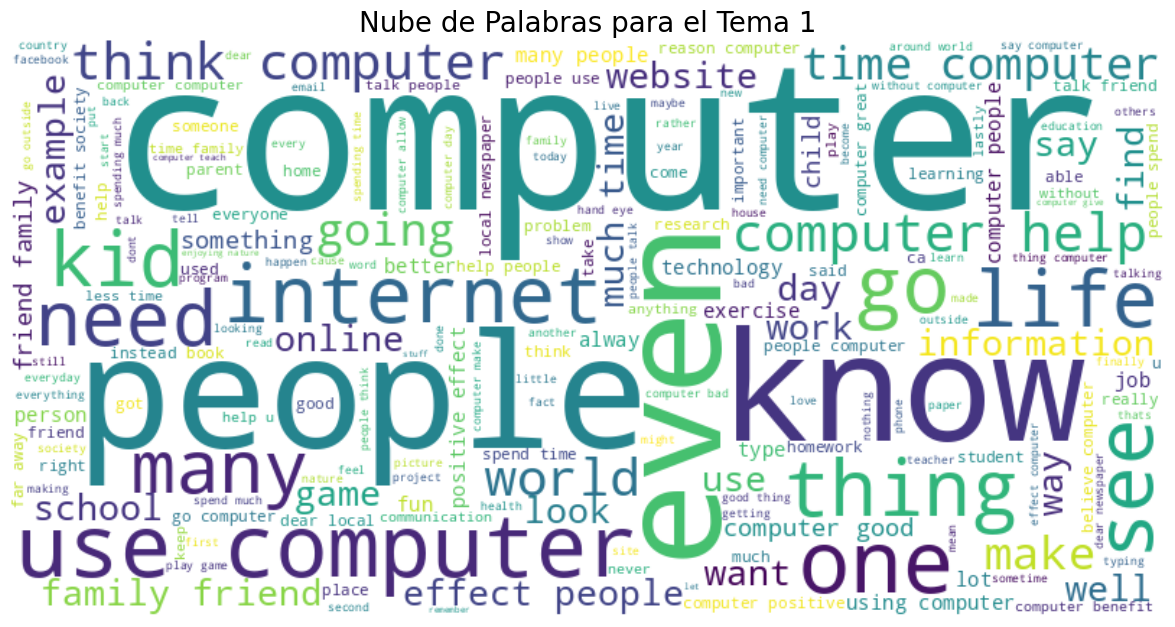

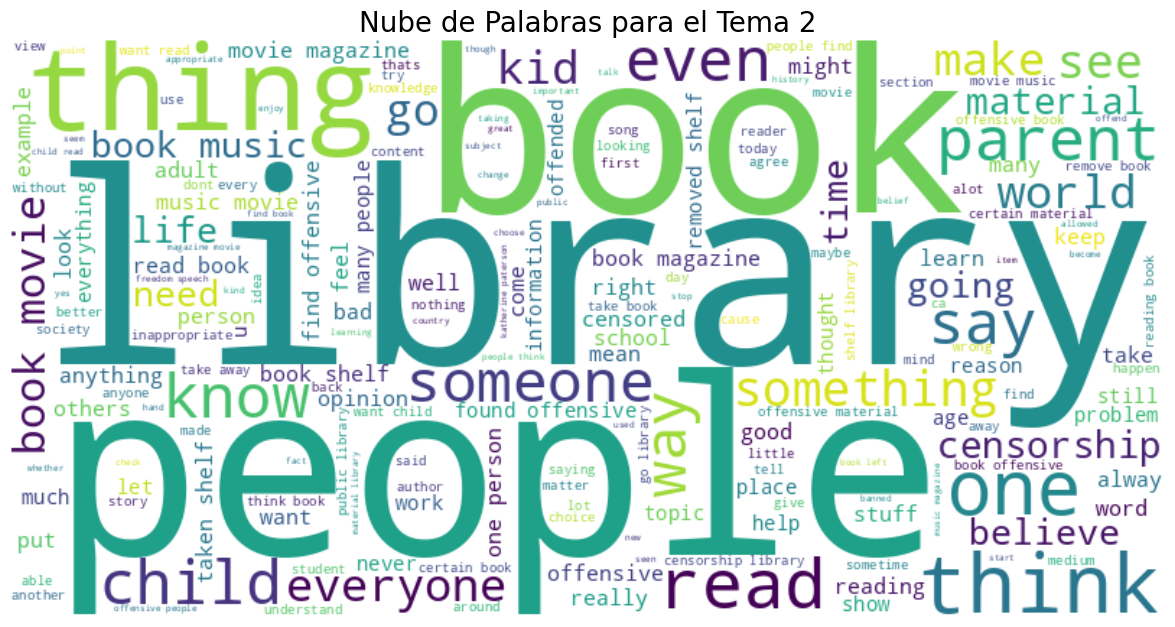

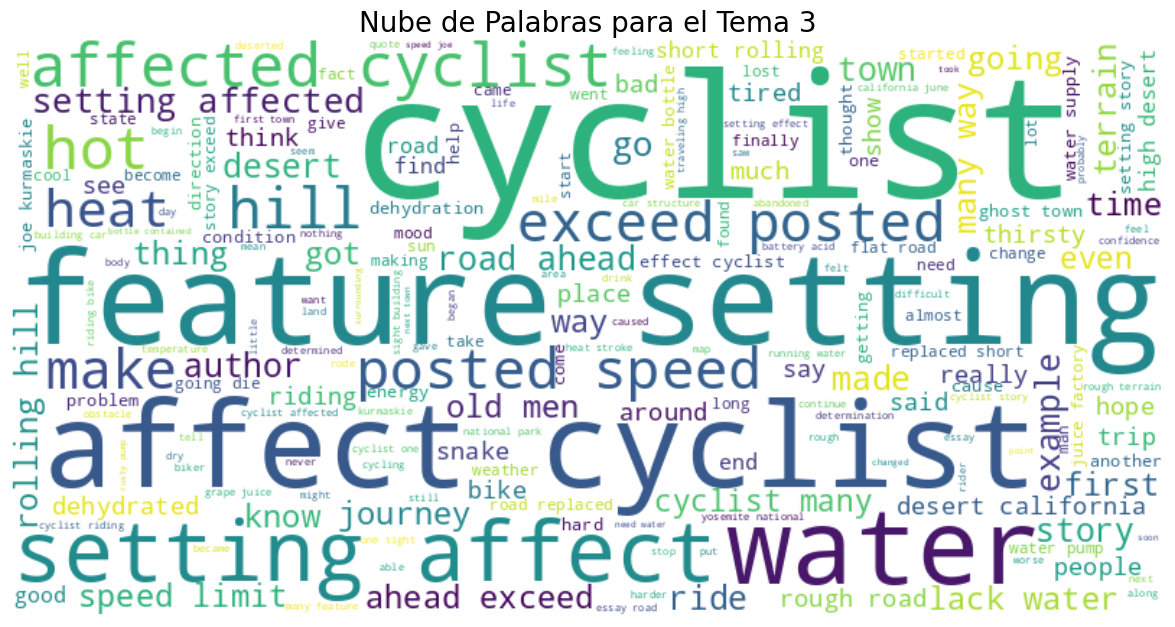

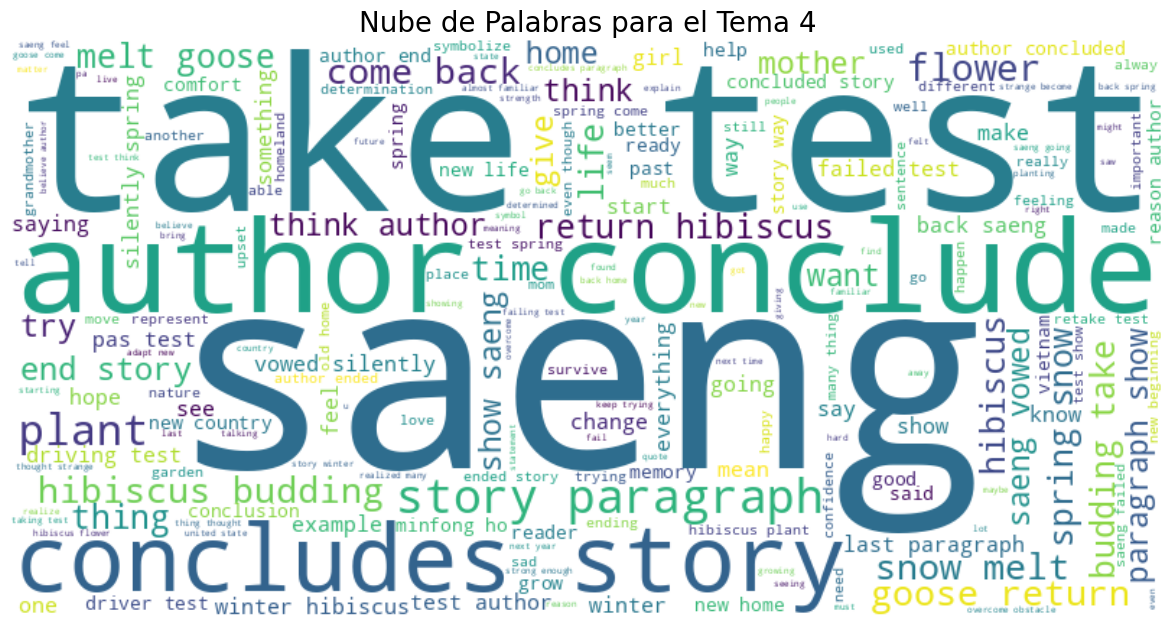

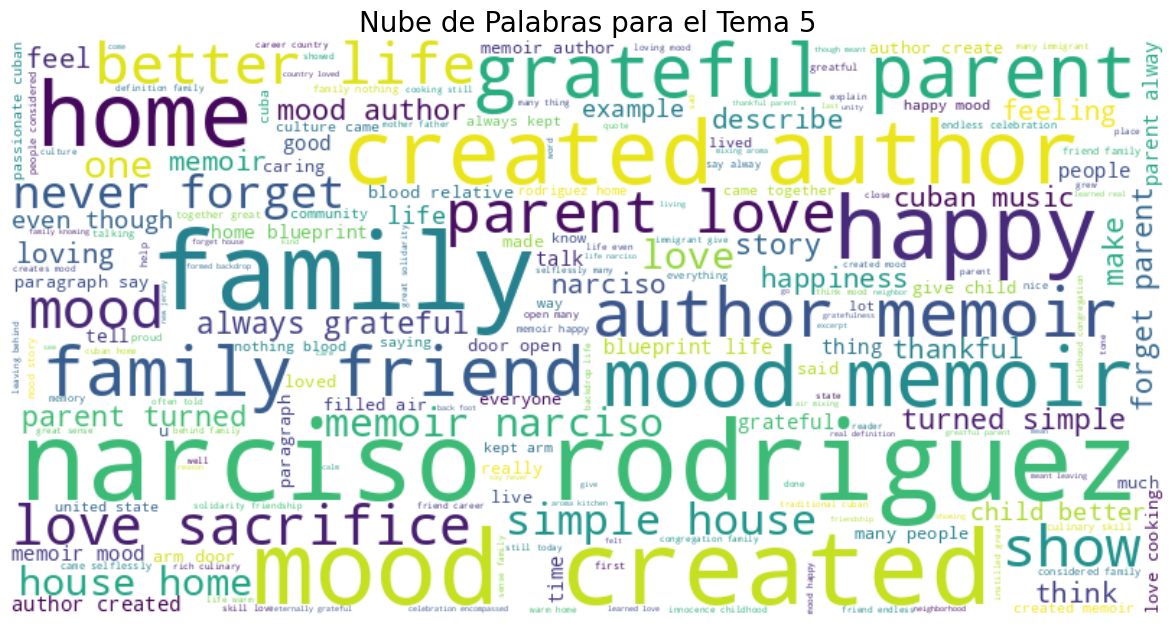

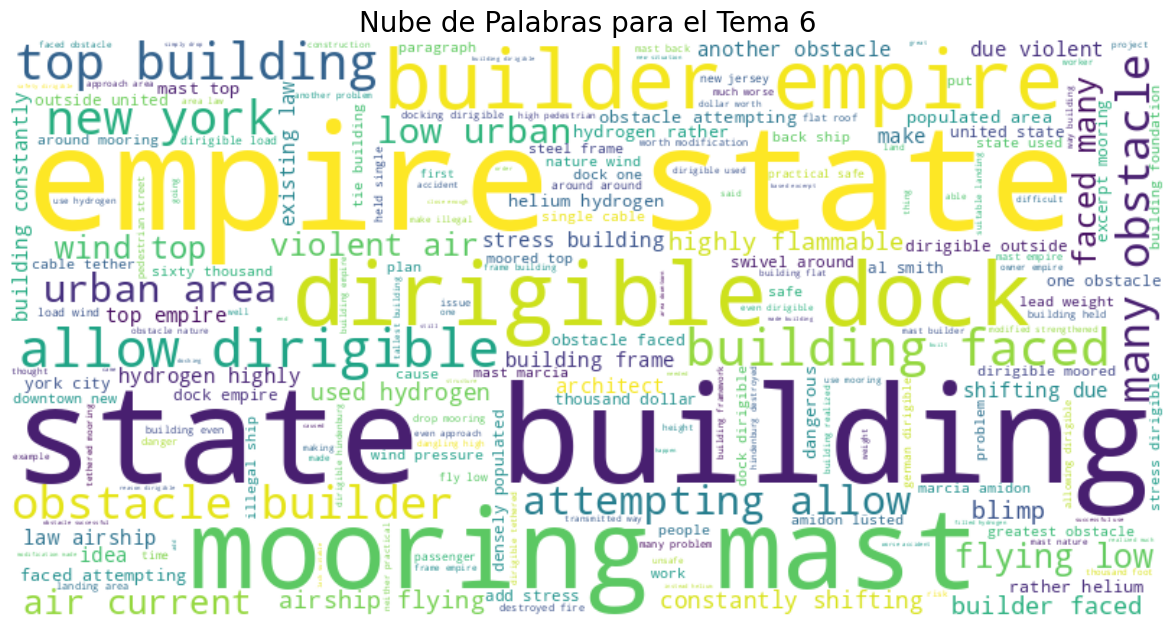

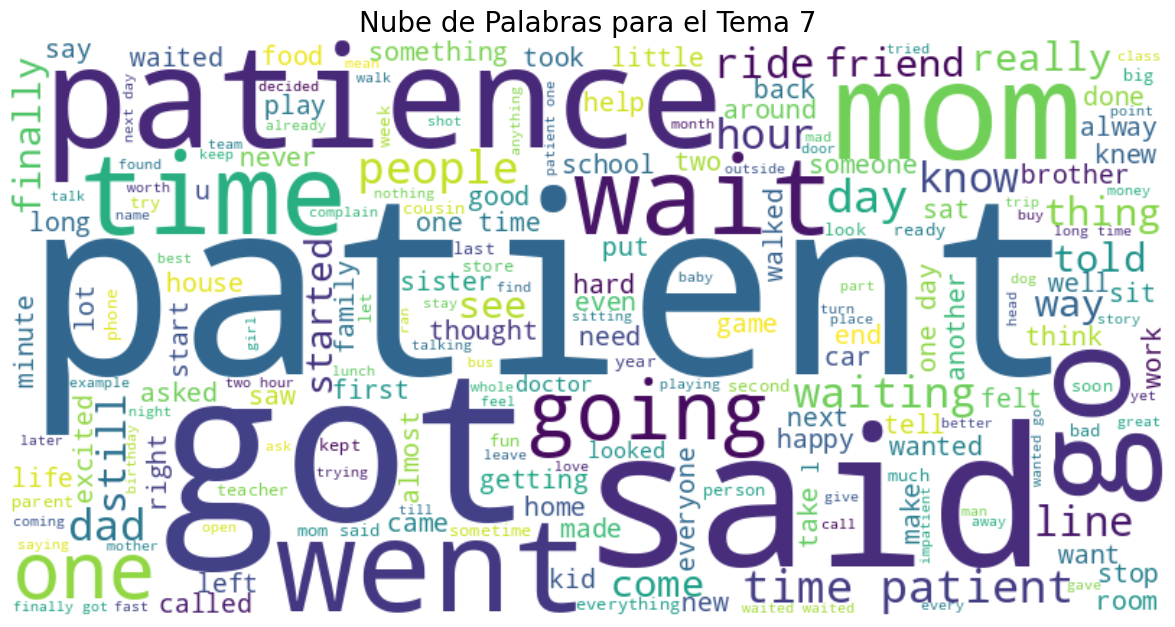

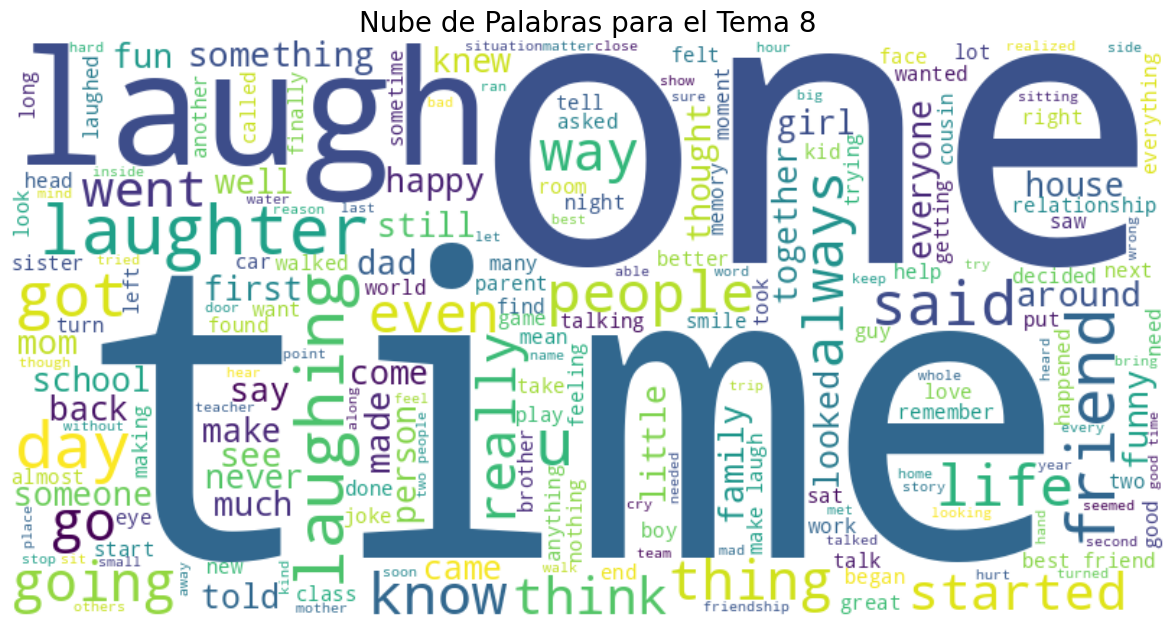

In [27]:
# Concatenación de todos los ensayos por tema
topic_texts = data.groupby('topic')['processed_essay'].apply(lambda x: ' '.join([' '.join(words) for words in x]))

# Generación de nubes de palabras para cada tema
for topic, text in topic_texts.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Nube de Palabras para el Tema {topic}', fontsize=20)
    plt.show()

In [28]:
# Codificación de la variable objetivo
label_encoder = LabelEncoder()
data['topic_encoded'] = label_encoder.fit_transform(data['topic'])

# División de datos en entrenamiento y prueba
X = data['processed_essay']
y = data['topic_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LDA sin TF-IDF

In [29]:
# Creación del diccionario y corpus
dictionary = corpora.Dictionary(X_train)
corpus = [dictionary.doc2bow(text) for text in X_train]

# Entrenamiento del modelo LDA
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=8, random_state=42)

# Asignación de tópicos a los documentos de entrenamiento
def get_topic_distribution(model, corpus):
    topic_distribution = []
    for doc in corpus:
        topics = model.get_document_topics(doc)
        topics = sorted(topics, key=lambda x: x[1], reverse=True)
        topic_distribution.append(topics[0][0])
    return topic_distribution

train_topics = get_topic_distribution(lda_model, corpus)

# Evaluación en entrenamiento
accuracy = accuracy_score(y_train, train_topics)
print(f'Accuracy LDA sin TF-IDF (Entrenamiento): {accuracy}')


Accuracy LDA sin TF-IDF (Entrenamiento): 0.3244701348747592


LDA con TF-IDF

In [30]:
# Creación del modelo TF-IDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Entrenamiento del modelo LDA con TF-IDF
lda_tfidf_model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=8, random_state=42)

# Asignación de tópicos a los documentos de entrenamiento
train_topics_tfidf = get_topic_distribution(lda_tfidf_model, corpus_tfidf)

# Evaluación en entrenamiento
accuracy_tfidf = accuracy_score(y_train, train_topics_tfidf)
print(f'Accuracy LDA con TF-IDF (Entrenamiento): {accuracy_tfidf}')

Accuracy LDA con TF-IDF (Entrenamiento): 0.24739884393063583


In [31]:
# Procesamiento de los documentos de prueba
corpus_test = [dictionary.doc2bow(text) for text in X_test]

# Para TF-IDF
corpus_test_tfidf = tfidf[corpus_test]

 Evaluación de LDA sin TF-IDF en Prueba

In [32]:
# Asignación de tópicos a los documentos de prueba
test_topics = get_topic_distribution(lda_model, corpus_test)

# Evaluación en prueba
accuracy_test = accuracy_score(y_test, test_topics)
print(f'Accuracy LDA sin TF-IDF (Prueba): {accuracy_test}')

Accuracy LDA sin TF-IDF (Prueba): 0.31856702619414484


Evaluación de LDA con TF-IDF en Prueba

In [33]:
# Asignación de tópicos a los documentos de prueba
test_topics_tfidf = get_topic_distribution(lda_tfidf_model, corpus_test_tfidf)

# Evaluación en prueba
accuracy_test_tfidf = accuracy_score(y_test, test_topics_tfidf)
print(f'Accuracy LDA con TF-IDF (Prueba): {accuracy_test_tfidf}')

Accuracy LDA con TF-IDF (Prueba): 0.24114021571648692


In [45]:
def get_topic_probabilities(model, corpus, num_topics):
    topic_probabilities = []
    for doc in corpus:
        topics = model.get_document_topics(doc, minimum_probability=0)
        topic_dist = [0] * num_topics
        for topic_num, prob in topics:
            topic_dist[topic_num] = prob
        topic_probabilities.append(topic_dist)
    return np.array(topic_probabilities)

num_topics = 8

test_topic_probs = get_topic_probabilities(lda_model, corpus_test, num_topics)

In [46]:
# Calcular el ROC AUC
y_test_array = np.array(y_test)
roc_auc_lda = roc_auc_score(y_test_array, test_topic_probs, multi_class='ovr')
print(f'ROC AUC LDA sin TF-IDF: {roc_auc_lda}')

ROC AUC LDA sin TF-IDF: 0.6657689664741353


In [47]:
test_topic_probs_tfidf = get_topic_probabilities(lda_tfidf_model, corpus_test_tfidf, num_topics)
roc_auc_lda_tfidf = roc_auc_score(y_test_array, test_topic_probs_tfidf, multi_class='ovr')
print(f'ROC AUC LDA con TF-IDF: {roc_auc_lda_tfidf}')

ROC AUC LDA con TF-IDF: 0.6648272718807415


Implementación con BERT

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [39]:
# Función para obtener embeddings de BERT
def get_bert_embeddings(texts):
    embeddings = []
    for text in texts:
        inputs = tokenizer(' '.join(text), return_tensors='pt', truncation=True, max_length=512)
        outputs = bert_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :].detach().numpy()
        embeddings.append(cls_embedding.flatten())
    return np.array(embeddings)

# Obtención de embeddings para entrenamiento y prueba
X_train_embeddings = get_bert_embeddings(X_train)
X_test_embeddings = get_bert_embeddings(X_test)


Clasificación con BERT Embeddings

In [40]:
# Entrenamiento de un clasificador (por ejemplo, SVM)
classifier = SVC(probability=True, random_state=42)
classifier.fit(X_train_embeddings, y_train)

# Predicciones en prueba
y_pred = classifier.predict(X_test_embeddings)

# Evaluación
accuracy_bert = accuracy_score(y_test, y_pred)
roc_auc_bert = roc_auc_score(y_test, classifier.predict_proba(X_test_embeddings), multi_class='ovr')
print(f'Accuracy BERT: {accuracy_bert}')
print(f'ROC AUC BERT: {roc_auc_bert}')

Accuracy BERT: 0.9845916795069337
ROC AUC BERT: 0.9996576178985253


Implementación con FastText

In [41]:
import fasttext

# Preparación de datos para FastText
def prepare_fasttext_data(X, y, filename):
    with open(filename, 'w') as f:
        for text, label in zip(X, y):
            f.write(f'__label__{label} {" ".join(text)}\n')

# Creación de archivos de entrenamiento y prueba
prepare_fasttext_data(X_train, y_train, 'train.txt')
prepare_fasttext_data(X_test, y_test, 'test.txt')

# Entrenamiento del modelo FastText
fasttext_model = fasttext.train_supervised('train.txt', lr=1.0, epoch=25, wordNgrams=2, verbose=2, minCount=1)

# Evaluación en prueba
result = fasttext_model.test('test.txt')
print(f'Accuracy FastText: {result[1]}')

Read 1M words
Number of words:  30169
Number of labels: 8
Progress:  97.9% words/sec/thread:  878952 lr:  0.020822 avg.loss:  0.013961 ETA:   0h 0m 0s

Accuracy FastText: 0.9922958397534669


Progress: 100.0% words/sec/thread:  865708 lr:  0.000000 avg.loss:  0.013712 ETA:   0h 0m 0s


In [ ]:
# Obtener todas las etiquetas y probabilidades
num_classes = len(set(y_train))  # Número de clases

labels_k, probabilities_k = fasttext_model.predict([' '.join(text) for text in X_test], k=num_classes)

from sklearn.preprocessing import label_binarize
y_test_array = np.array(y_test)
classes = np.unique(y_test_array)
y_test_binarized = label_binarize(y_test_array, classes=classes)
n_classes = y_test_binarized.shape[1]

scores_matrix = np.zeros((len(X_test), n_classes))

for i, (label_list, prob_list) in enumerate(zip(labels_k, probabilities_k)):
    for label, prob in zip(label_list, prob_list):
        class_index = int(label.replace('__label__', ''))
        scores_matrix[i, class_index] = prob

# Calcular el ROC AUC por clase
from sklearn.metrics import roc_auc_score

roc_auc_scores = []
for i in range(n_classes):
    try:
        roc_auc = roc_auc_score(y_test_binarized[:, i], scores_matrix[:, i])
        roc_auc_scores.append(roc_auc)
    except ValueError:
        roc_auc_scores.append(np.nan)

# Calcular el ROC AUC promedio
roc_auc_fasttext = np.nanmean(roc_auc_scores)
print(f'ROC AUC FastText (promedio por clase): {roc_auc_fasttext}')

ROC AUC FastText (promedio por clase): 0.9994683829377071


Evaluación y Comparación de Métodos


In [54]:
results = pd.DataFrame({
    'Method': ['LDA', 'LDA_TFIDF', 'BERT', 'FastText'],
    'Accuracy': [accuracy_test, accuracy_test_tfidf, accuracy_bert, result[1]],
    'ROC AUC': [roc_auc_lda, roc_auc_lda_tfidf, roc_auc_bert, roc_auc_fasttext]
})

results = results.sort_values(by='ROC AUC', ascending=False)
print(results)

      Method  Accuracy   ROC AUC
2       BERT  0.984592  0.999658
3   FastText  0.992296  0.999468
0        LDA  0.318567  0.665769
1  LDA_TFIDF  0.241140  0.664827
